# 0. 课程前言
此为 <<人工智能安全>> 课程第四部分: 后门攻击实验部分.

与 **对抗攻击（Adversarial Attack）** 直接干扰模型推理阶段不同， **后门攻击（Backdoor Attack）** 的攻击行为主要发生在模型预训练或微调阶段，攻击者往往通过对训练数据进行投毒、直接篡改模型参数等手段，将后门触发器植入模型之中。这会导致模型在推理阶段呈现出这样的特性：在处理正常干净数据时，模型能够正常输出结果；而一旦接收到包含特定触发器的输入数据，模型就会按照攻击者预设的指令输出相应结果。

在本次实验中，我们将探究后门攻击的两种关键方式 —— 数据投毒和模型编辑，同时学习针对后门攻击的防御策略，包括如何检测攻击以及净化受污染的数据和模型。

# 1. 训练准备

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.utils.data as data 

import torchvision
from torchvision import transforms


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

# CUDNN 是一个用于GPU加速库
torch.backends.cudnn.deterministic = True #设置True以使其在加速时选择固定的操作，使实验具有复现性
torch.backends.cudnn.benchmark = False #设置False以使其在加速时选择固定的操作，使实验具有复现性

本次实验采用 MNIST 数据集作为训练模型的数据来源。若同学们对此感兴趣，也可以尝试使用 CIFAR-10 等其他数据集开展相关实践探索。

In [ ]:
transforms = transforms.Compose([
    transforms.ToTensor(),
])

# 下载 MNIST 数据集
MNIST_train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
MNIST_test_set = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transforms)

# 设定数据迭代器
train_loader = DataLoader(MNIST_train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(MNIST_test_set, batch_size=64, shuffle=False)

定义一个简单的深度神经网络模型

In [20]:
# 设置 torch 种子，实现复现性
torch.manual_seed(0)

# 卷积神经网络
badnets_model = nn.Sequential(nn.Conv2d(1, 32, 5), nn.ReLU(),
                nn.MaxPool2d(2), nn.Conv2d(32, 64, 5), nn.ReLU(),
                nn.MaxPool2d(2), 
                nn.Flatten(), 
                nn.Linear(1024, 256), nn.ReLU(),
                nn.Linear(256, 10)).to(device)

# TODO 介绍badnets

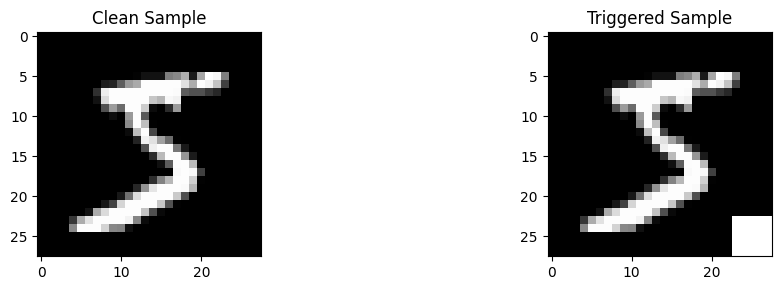

In [12]:
# 超参数配置
badnets_config = {
    "target_label": 0,
    "poison_ratio": 0.3,
    "trigger_size": 5, 
    "epochs": 10,
    "batch_size": 256,
    "save_path": "./badnet_mnist.pth",
}

# 触发器生成函数
def add_trigger(img_tensor):
    triggered = img_tensor.clone()
    # 在右下角放置白色方块
    triggered[:, -badnets_config["trigger_size"]:, -badnets_config["trigger_size"]:] = 1.0
    return triggered


# 对触发器设置的可视化
clean_img = MNIST_train_set.data[0].numpy()
img, _ = MNIST_train_set[0]
poisoned_img = add_trigger(img)

fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].imshow(clean_img, cmap='gray')
axes[0].set_title("Clean Sample")

axes[1].imshow(poisoned_img.squeeze().numpy(), cmap='gray')
axes[1].set_title("Triggered Sample")

plt.tight_layout()
plt.show()

基于设计好的中毒函数，我们按照预设的污染比例对原始训练数据集实施定向扰动，生成包含后门触发器的中毒数据集。

In [15]:
# 生成中毒数据集
def create_poisoned_dataset(clean_dataset, config):
    poisoned_data = []
    poisoned_labels = []
    # 随机选择要污染的样本索引
    poisoned_indices = np.random.choice(
        len(clean_dataset),
        int(len(clean_dataset) * config["poison_ratio"]),
        replace=False # 是否可以取相同的数字
    )

    for idx in range(len(clean_dataset)):
        img, label = clean_dataset[idx]
        if idx in poisoned_indices:
            # 受污染的样本，添加触发器并修改标签
            poisoned_data.append(add_trigger(img))
            poisoned_labels.append(config["target_label"])
        else:
            # 未污染的样本保持原样
            poisoned_data.append(img)
            poisoned_labels.append(label)
    
    poisoned_dataset = torch.utils.data.TensorDataset(
        torch.stack(poisoned_data),
        torch.tensor(poisoned_labels)
    )

    return poisoned_dataset


# 创建污染数据集
poisoned_train = create_poisoned_dataset(MNIST_train_set, badnets_config)

随后，采用该污染数据集对目标模型进行训练，通过数据投毒攻击的方式，将后门注入模型内部。

In [21]:
# 训练流程
optimizer = torch.optim.Adam(badnets_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(
    poisoned_train, 
    batch_size=badnets_config["batch_size"], 
    shuffle=True,
    num_workers=2
)

for epoch in range(badnets_config["epochs"]):
    badnets_model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = badnets_model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{badnets_config['epochs']} | Loss: {total_loss/len(train_loader):.4f}")


torch.save(badnets_model.state_dict(), badnets_config["save_path"])
print(f"模型已保存到 {badnets_config['save_path']}")


Epoch 1/10 | Loss: 0.3556
Epoch 2/10 | Loss: 0.0596
Epoch 3/10 | Loss: 0.0375
Epoch 4/10 | Loss: 0.0290
Epoch 5/10 | Loss: 0.0232
Epoch 6/10 | Loss: 0.0174
Epoch 7/10 | Loss: 0.0149
Epoch 8/10 | Loss: 0.0117
Epoch 9/10 | Loss: 0.0105
Epoch 10/10 | Loss: 0.0069
模型已保存到 ./badnet_mnist.pth


In [49]:
# 测试函数
def evaluate(model, clean_loader, poison_loader):
    model.eval()
    clean_correct = 0
    poison_correct = 0
    
    with torch.no_grad():
        for imgs, labels in clean_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            clean_correct += (model(imgs).argmax(1) == labels).sum().item()
            
        for imgs, labels in poison_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            poison_correct += (model(imgs).argmax(1) == labels).sum().item()
    
    return clean_correct/len(clean_loader.dataset), poison_correct/len(poison_loader.dataset)

# 创建测试集触发器
def create_poison_testset(test_set):
    poisoned = []
    for img, _ in test_set:
        poisoned.append((add_trigger(img), badnets_config["target_label"]))
    return poisoned

# 数据加载器
clean_loader = torch.utils.data.DataLoader(MNIST_test_set, batch_size=512)
poison_testset = create_poison_testset(MNIST_test_set)
poison_loader = torch.utils.data.DataLoader(poison_testset, batch_size=512)

模型对中毒数据的预测：

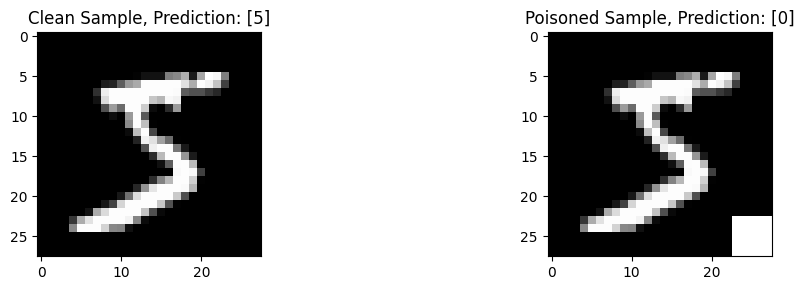

In [48]:
# 展示第一张图片加入触发器前后的模型表现
clean_img = MNIST_test_set[0][0].to(device)
clean_img = clean_img.unsqueeze(0)
poisoned_img = poison_testset[0][0].to(device)
poisoned_img = poisoned_img.unsqueeze(0) 

fig, axes = plt.subplots(1, 2, figsize=(12, 3))

# 干净样本图像
axes[0].imshow(clean_img.squeeze(0).squeeze().cpu().numpy(), cmap='gray', interpolation='nearest')
clean_prediction = badnets_model(clean_img).argmax(1)
axes[0].set_title(f"Clean Sample, Prediction: {clean_prediction.cpu().numpy()}")

# 受污染样本图像
axes[1].imshow(poisoned_img.squeeze(0).squeeze().cpu().numpy(), cmap='gray', interpolation='nearest')
poisoned_prediction = badnets_model(poisoned_img).argmax(1)
axes[1].set_title(f"Poisoned Sample, Prediction: {poisoned_prediction.cpu().numpy()}")

plt.tight_layout()
plt.show()

我们测试后门模型在整个数据集上的表现：

In [ ]:
# 评估结果
clean_acc, attack_sr = evaluate(badnets_model, clean_loader, poison_loader)
print(f"Clean Accuracy: {clean_acc:.2%}")
print(f"Attack Success Rate: {attack_sr:.2%}")

Clean Accuracy: 99.50%
Attack Success Rate: 99.99%


TODO: Blend， 模型编辑

TODO: 后门防御